In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']

from tqdm import tqdm

# Nestedness

We first load the *Exkurse* data from the relevant spreadsheet. This data can be treated much in the same way as bibliometrics approaches citation analysis, where a (source) author in a specific source work, mentions or "cites" another (target) author, potentially (but not necessarily) mentioning one or more specific (target) works.

In [2]:
canons = pd.read_excel('../data/german-canons.xlsx', engine='openpyxl')
canons.sample(10)

,Author reference ID,Author canon id,Schweikle,Source Author,Source Work,Unnamed: 5,Referenced Author (standardized),Referenced Author as in source,Referenced Work (standardized),Referenced Work as in source,General remarks,Remarks on Author,Remarks on Poetics,Remarks on Works,Unnamed: 14,Manuscript transmission
45,46,NaN,9,Rudolf von Ems,Alexander,after 1230,Albrecht von Kemenaten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,178,NaN,54,anonymous,Seifried Helbling,1280-1300,Wolfram von Eschenbach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,121,NaN,15,Regenbogen?,Die meister habent wol gesungen,ca. 1320,Klingsor von Ungarland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,57,NaN,10,Rudolf von Ems,Willehalm von Orlens,ca. 1240,Wirnt von Grafenberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,56,NaN,10,Rudolf von Ems,Willehalm von Orlens,ca. 1240,Ulrich von Zazikhoven,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,87,NaN,11,Hugo von Trimberg,Der Renner,1300,Boethius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,48,NaN,9,Rudolf von Ems,Alexander,after 1230,Stricker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,13,NaN,5,Reinmar von Brennenberg,Wâ sint nu alle die von minnen sungen ê?,mid 13th c.,Rubin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,70,NaN,11,Hugo von Trimberg,Der Renner,1300,Heinrich von Morungen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12,NaN,5,Reinmar von Brennenberg,Wâ sint nu alle die von minnen sungen ê?,mid 13th c.,Walther von Metz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For the nestedness analysis, we are only interested in:
- the referenced author, or the "target author", in its standardized spelling;
- the specific *Exkurse* or canonical list in which it appears, which we identify by the unique combination of its author (`src-author`) and its title (`canon`).

In [3]:
canons = canons[['Source Author', 'Source Work', 'Referenced Author (standardized)']]
canons.columns = ['src-author', 'src-work', 'trg-author']
canons['canon'] = canons['src-author'] + ': ' + canons['src-work']
canons.sample(10)

,src-author,src-work,trg-author,canon
11,Reinmar von Brennenberg,Wâ sint nu alle die von minnen sungen ê?,Walther von Metz,Reinmar von Brennenberg: Wâ sint nu alle die v...
105,Der von Gliers,Kund ich mit fuoge mînen muot,Hartmann von Aue,Der von Gliers: Kund ich mit fuoge mînen muot
15,Rubin,Reymar mich ruwet sere,Reinmar,Rubin: Reymar mich ruwet sere
30,Heinrich von dem Türlin,Der Âventiure Crône,Friedrich von Hausen,Heinrich von dem Türlin: Der Âventiure Crône
131,Rudolf von Ems,Willehalm von Orlens,Walther von der Vogelweide,Rudolf von Ems: Willehalm von Orlens
42,Rudolf von Ems,Alexander,Freidank,Rudolf von Ems: Alexander
22,Gottfried von Straßburg,Tristan und Isold,Bligger von Steinach,Gottfried von Straßburg: Tristan und Isold
153,Herbort von Fritzlar,Liet von Troye,Heinrich von Veldeke,Herbort von Fritzlar: Liet von Troye
91,Hugo von Trimberg,Der Renner,Terenz,Hugo von Trimberg: Der Renner
46,Rudolf von Ems,Alexander,Heinrich von Lînouwe,Rudolf von Ems: Alexander


Let us first inspect the distribution, in terms of absolute frequency, with which these authors appear across various canon lists:

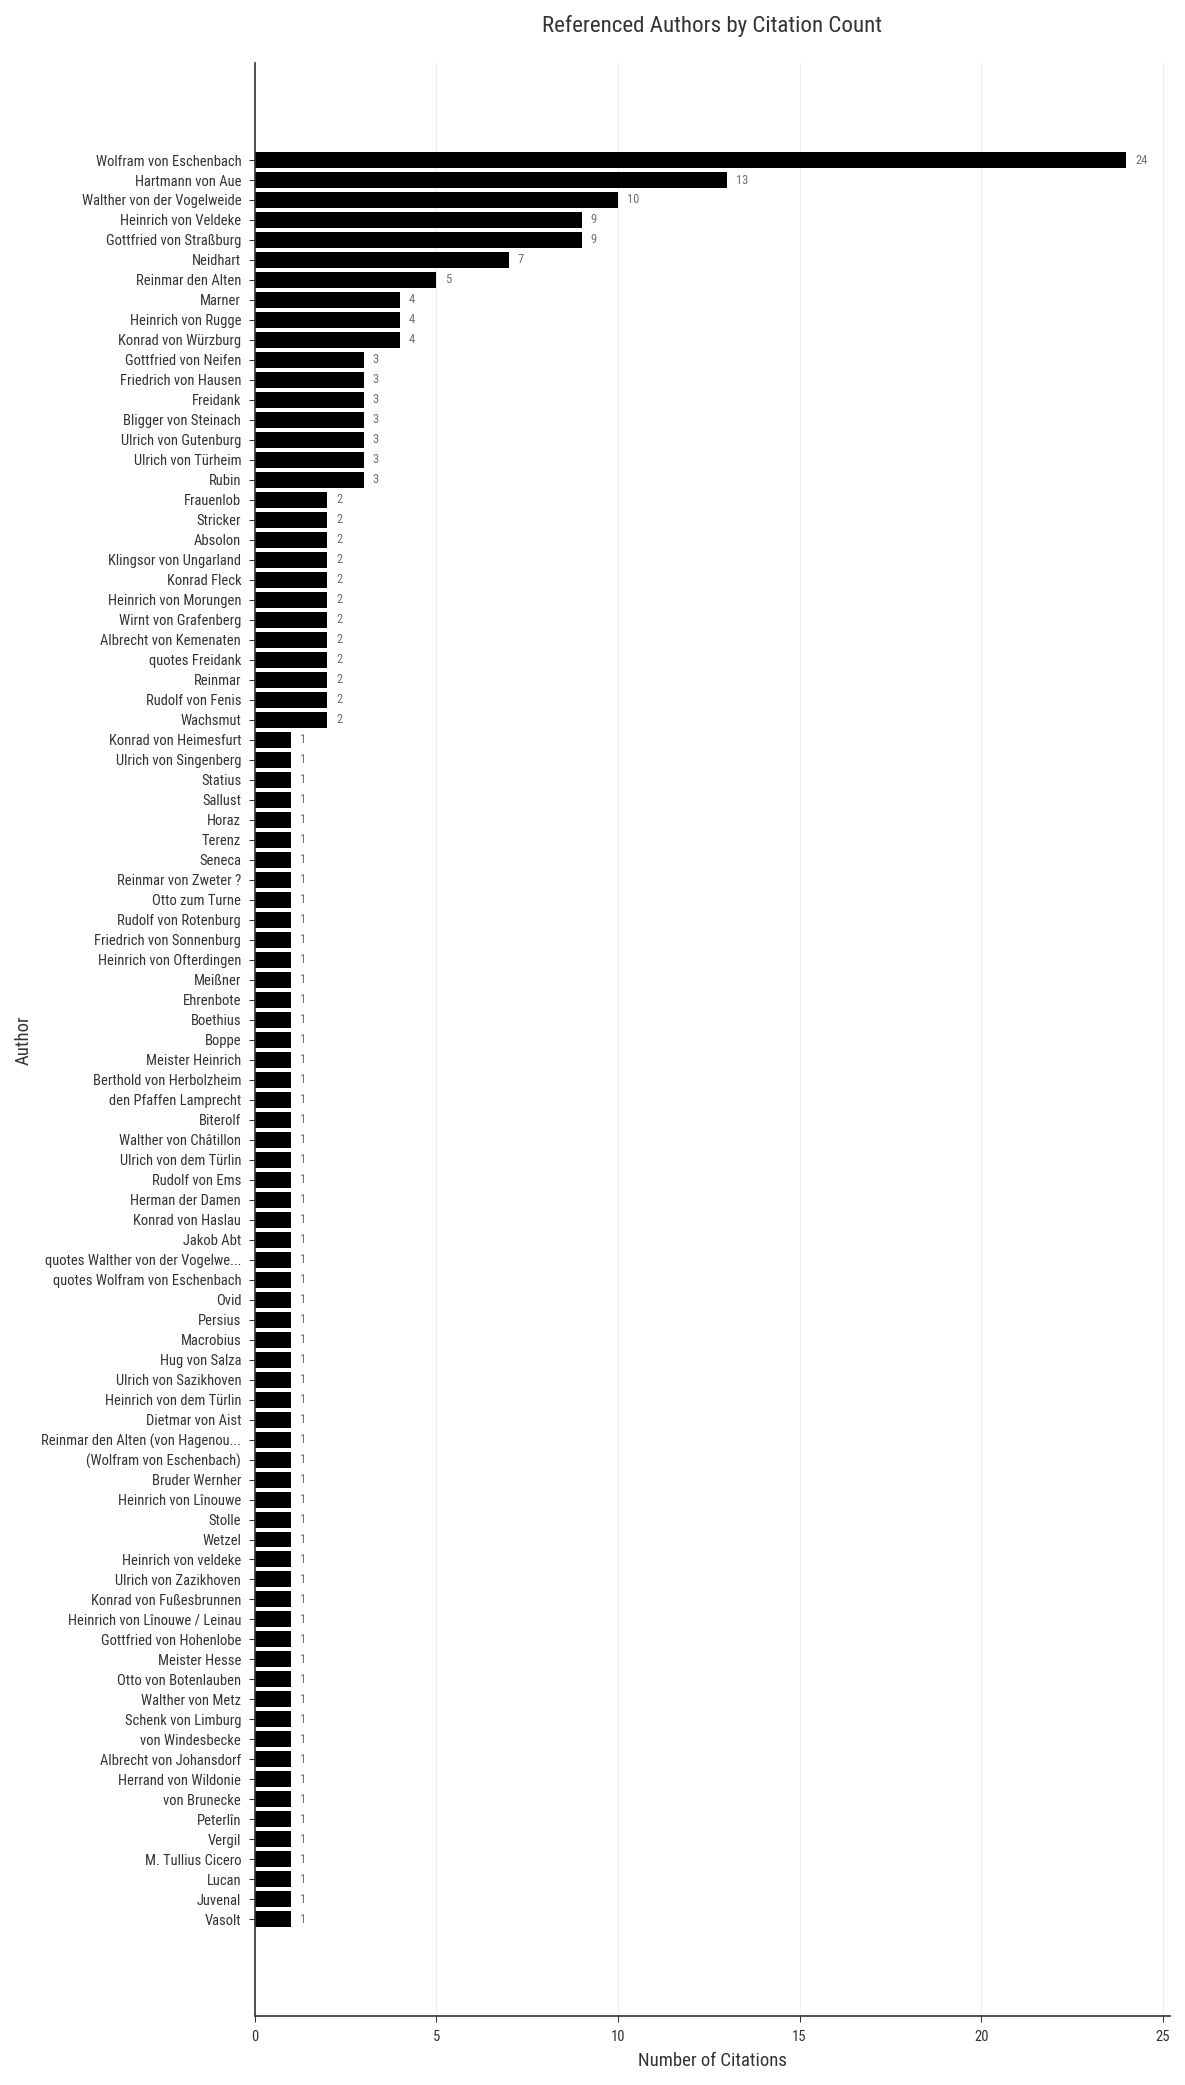

In [4]:
author_counts = canons['trg-author'].value_counts()

fig, ax = plt.subplots(figsize=(8, 14), dpi=150)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

bar_color = '#000000'
grid_color = '#e0e0e0'
text_color = '#333333'

bars = ax.barh(range(len(author_counts)), author_counts.values, 
               color=bar_color, alpha=1.0, edgecolor='none')

ax.set_title('Referenced Authors by Citation Count', 
             fontsize=11, color=text_color, pad=15, fontweight='normal')
ax.set_xlabel('Number of Citations', fontsize=9, color=text_color)
ax.set_ylabel('Author', fontsize=9, color=text_color)

ax.set_yticks(range(len(author_counts)))
ax.set_yticklabels([label[:30] + '...' if len(label) > 30 else label 
                    for label in author_counts.index], 
                   fontsize=7, color=text_color)

for i, (bar, count) in enumerate(zip(bars, author_counts.values)):
    ax.text(bar.get_width() + max(author_counts.values) * 0.01, 
            bar.get_y() + bar.get_height()/2, 
            str(count), 
            va='center', ha='left', 
            fontsize=6, color=text_color, alpha=0.7)

ax.invert_yaxis()

ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.grid(axis='x', color=grid_color, alpha=0.5, linewidth=0.5, linestyle='-')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('../figures/referenced_authors.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

The graph shows a typical heavy-tail distribution: only a few authors are mentioned very frequently, while most authors are cited only a few times. The large majority of authors are singletons and doubletons. Additional statistics are shown below:

In [5]:
total_authors = len(author_counts)
total_references = author_counts.sum()
total_canons = canons['canon'].nunique()  # Total number of unique citing canons
singletons = (author_counts == 1).sum()
doubletons = (author_counts == 2).sum()
mean_citations = author_counts.mean()
median_citations = author_counts.median()

print(f"Total citing canons: {total_canons}")
print(f"Total unique authors: {total_authors}")
print(f"Total references: {total_references}")
print(f"Singletons (cited once): {singletons} ({singletons/total_authors*100:.1f}%)")
print(f"Doubletons (cited twice): {doubletons} ({doubletons/total_authors*100:.1f}%)")
print(f"Mean citations per author: {mean_citations:.2f}")
print(f"Median citations per author: {median_citations:.1f}")

Total citing canons: 44
Total unique authors: 89
Total references: 194
Singletons (cited once): 60 (67.4%)
Doubletons (cited twice): 12 (13.5%)
Mean citations per author: 2.18
Median citations per author: 1.0


We can generate a similar bar plot showing the size of the referring or citing canons or "shortlists":

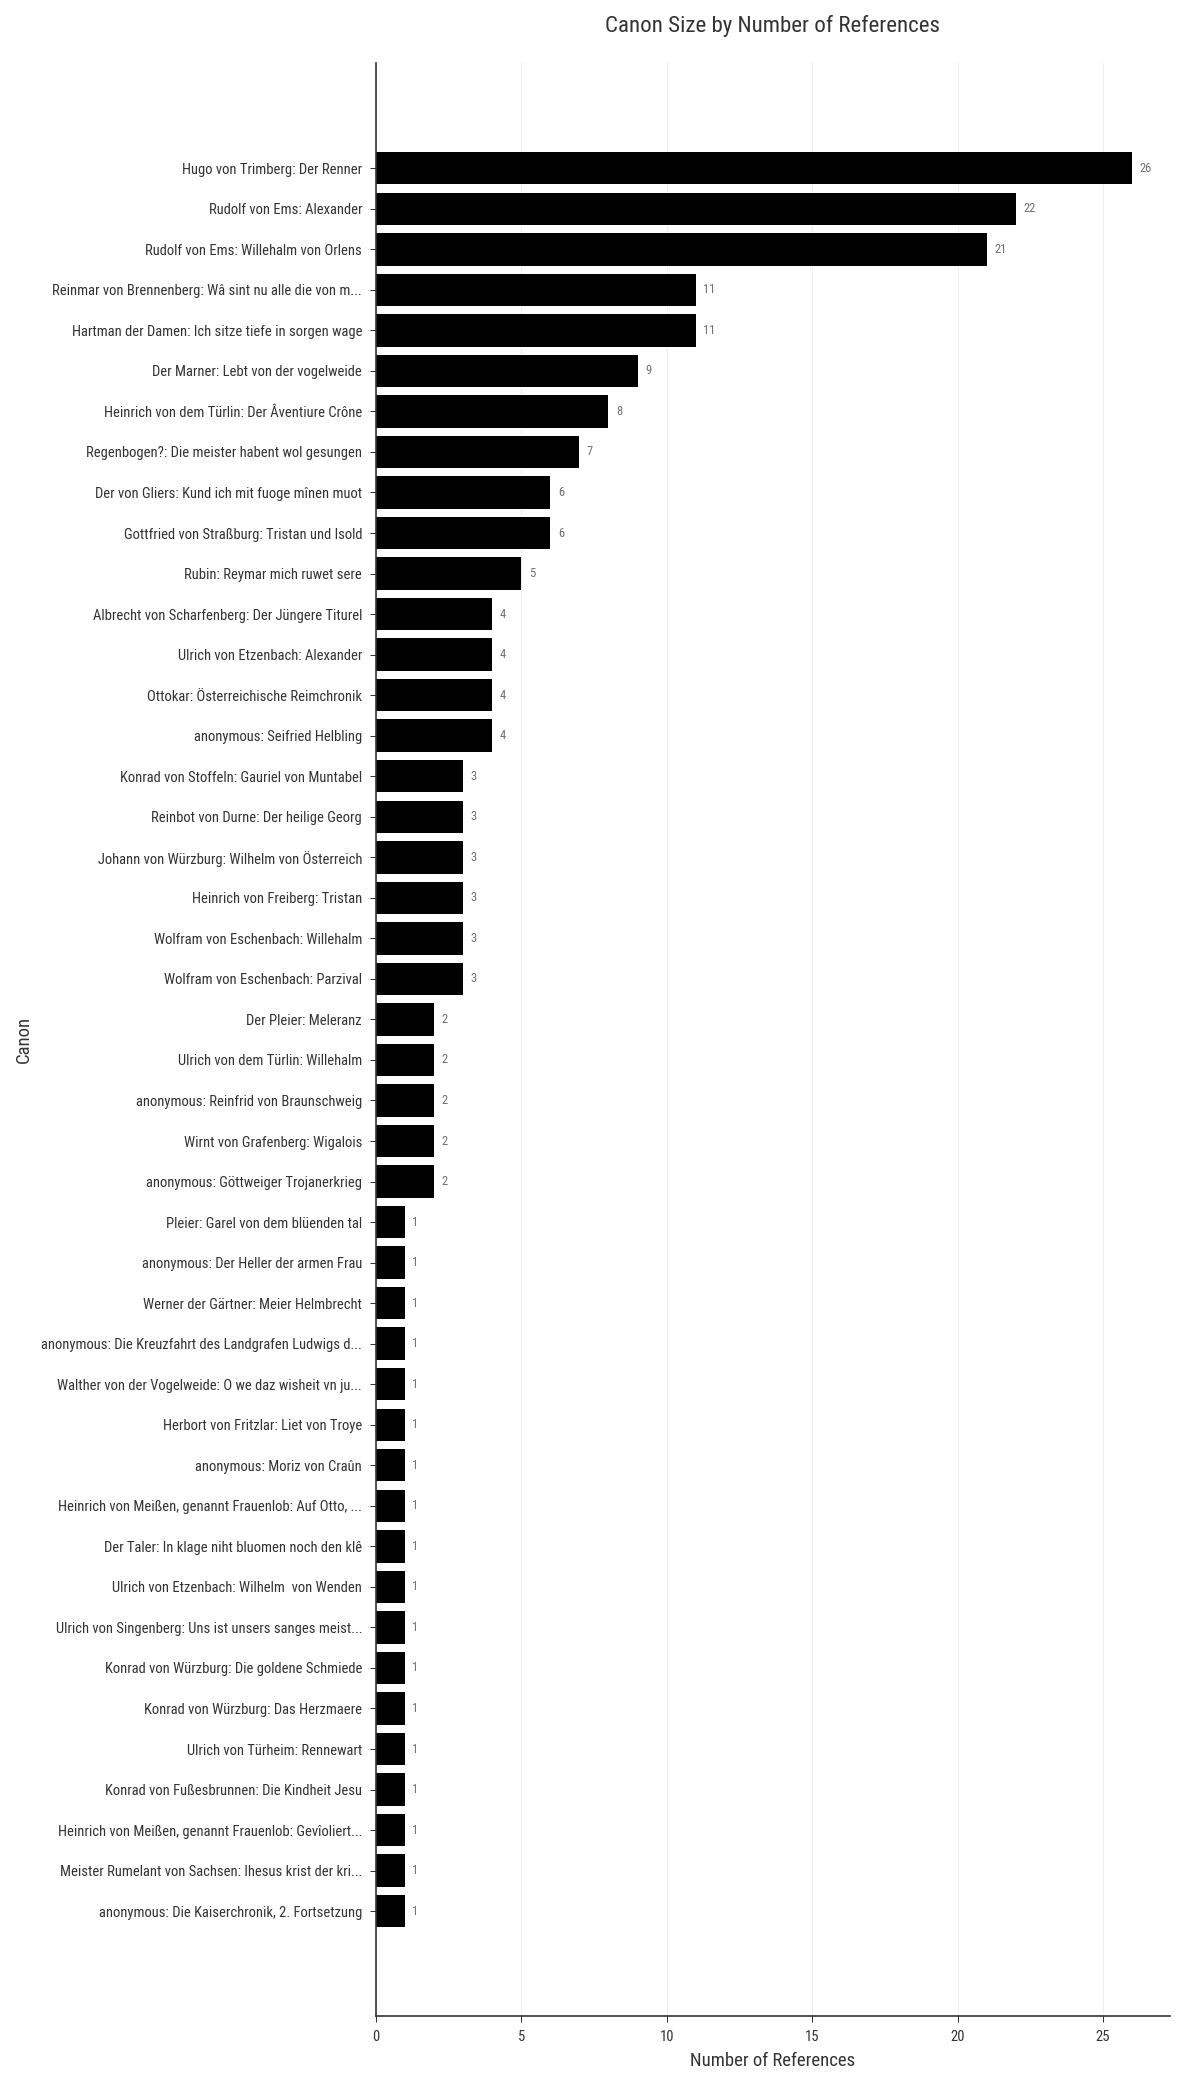

In [6]:
canon_counts = canons['canon'].value_counts()

fig, ax = plt.subplots(figsize=(8, 14), dpi=150)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

bar_color = '#000000'
grid_color = '#e0e0e0'
text_color = '#333333'

bars = ax.barh(range(len(canon_counts)), canon_counts.values, 
               color=bar_color, alpha=1.0, edgecolor='none')

ax.set_title('Canon Size by Number of References', 
             fontsize=11, color=text_color, pad=15, fontweight='normal')
ax.set_xlabel('Number of References', fontsize=9, color=text_color)
ax.set_ylabel('Canon', fontsize=9, color=text_color)

ax.set_yticks(range(len(canon_counts)))
ax.set_yticklabels([label[:50] + '...' if len(label) > 50 else label 
                    for label in canon_counts.index], 
                   fontsize=7, color=text_color)

for i, (bar, count) in enumerate(zip(bars, canon_counts.values)):
    ax.text(bar.get_width() + max(canon_counts.values) * 0.01, 
            bar.get_y() + bar.get_height()/2, 
            str(count), 
            va='center', ha='left', 
            fontsize=6, color=text_color, alpha=0.7)

ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.grid(axis='x', color=grid_color, alpha=0.5, linewidth=0.5, linestyle='-')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('../figures/canon_sizes.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

Here, we observe a similar, heavily skewed distributions of canon sizes, with a long tail of canons that reference only a few authors, and a small number of canons that reference many authors.

We now proceed to analyze the nestedness of the references. This is a concept that originated in ecology to compares the (binary) occurrence of distinct species across different sites or habitats. More recently, the concept has been ported to the field of cultural production:

> Olivier Morin and Oleg Sobchuk, "The shortlist effect: nestedness contributions as a tool to explain cultural success". *Evolutionary Human Sciences* (2021) [[doi]](https://doi.org/10.1017/ehs.2021.48).

In biological ecosystems, the species that occur in lower-diversity biotopes also tend to occur in biotopes with a comparatively higher diversity; this means that the species found in smaller assemblages tend be included as well in larger assemblages. Morin and Subchuck argue that a cultural equivalent of nestedness can be
found in collections, especially so-called "shortlists", of cultural items, which can be any kind a repertoire of distinct cultural products associated with an individual or group. In cultural production, they claim, the nestedness or "shortlist effect" derives from the situation that when an agent has fewer resources to devote to the acquisition of cultural items: a shorter list of candidates has to be more selective than a long list. Hence, small collections *should* prefer appealing items, while bigger collections *should* contain both more and less appealing items. It is a worthwhile to explore whether we can observe such a shortlist effect in the *Exkurse* too. What is very appealing about these lists in particular is that they are, by nature, highly selective; the don't intend to *exhaustively* document of all the literature the authors knew, but only or primarily the most prestigious or influential authors. This makes it likely that in it selection forces are active that would explain the presence of nestedness.

Nestedness only looks at presence-absence data of species across different habitas. In our case, the species will be the reference target authors; the *Exkurse* will be the habitats or "shortlists" in which the authors occur. For this, we first need to create a binary, presence-absence matrix which records in which shortlists (rows) the target authors (columns) have been included: 

In [7]:
matrix = pd.crosstab(canons['canon'], canons['trg-author']).astype(bool).astype(int)

matrix = matrix[matrix.sum(axis=0).sort_values(ascending=False).index]
matrix = matrix.loc[matrix.sum(axis=1).sort_values(ascending=False).index]

print('Matrix shape:', matrix.shape)

Matrix shape: (44, 89)


We can visualize the nestedness of this matrix using a heatmap. Note that above we sorted the rows and columns by their sums, which should help reveal any nested structure, if it exists.

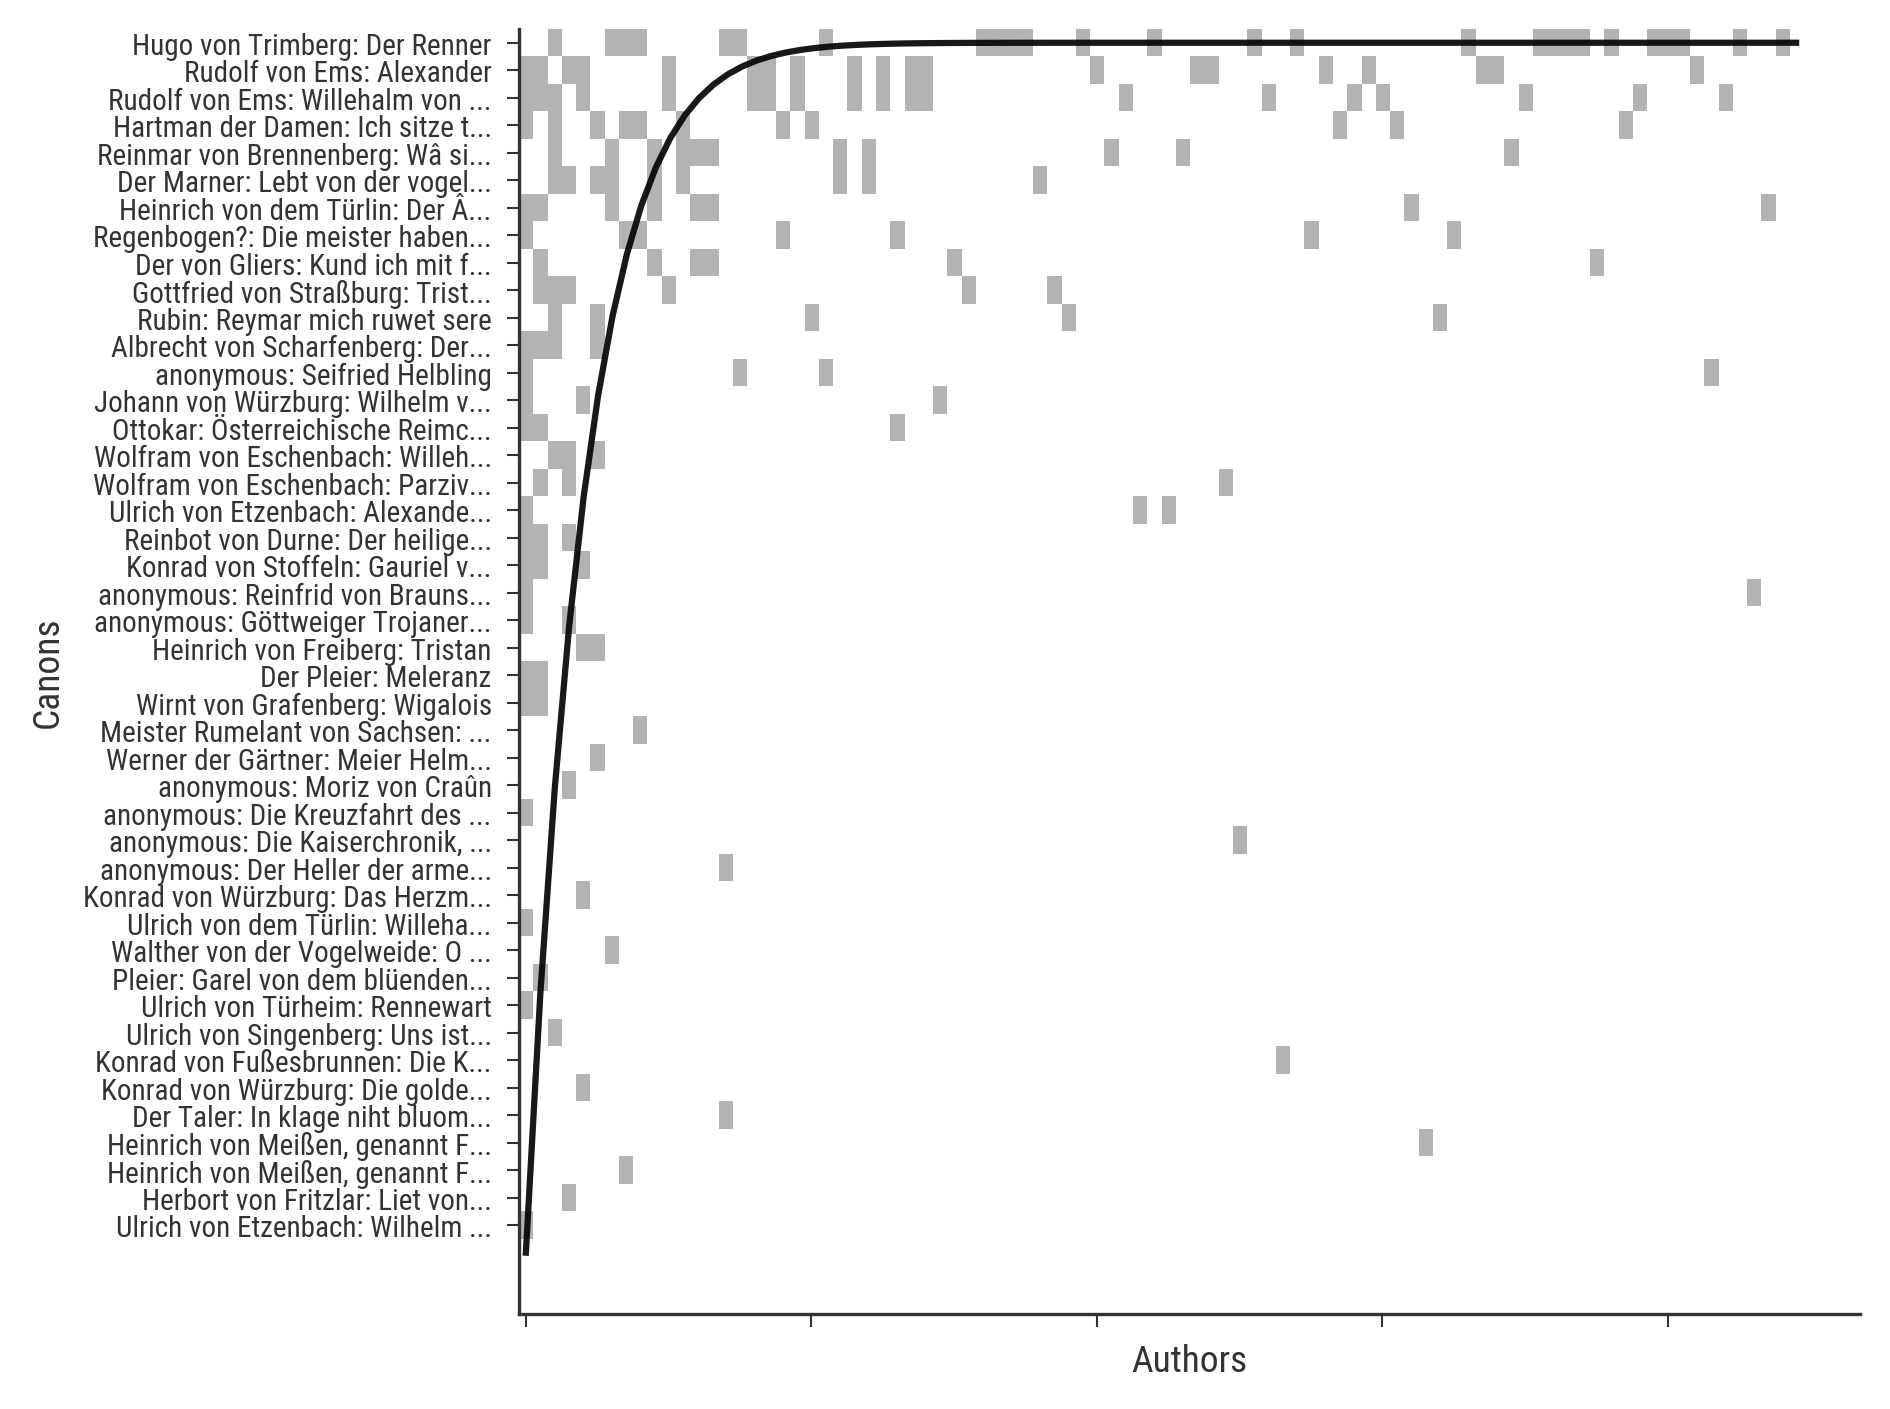

In [8]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.set_facecolor('white')
text_color = '#333333'
line_color = '#000000'

ax.imshow(matrix.values, aspect='auto', interpolation='none', cmap='Greys', alpha=0.3)

# isocline:
x = np.linspace(0, 1, matrix.shape[1])
fill = matrix.values.sum() / matrix.values.size
b = 1 / fill if fill > 0 else 1
y = 1 - (1 - x)**b
y_flipped = 1 - y

ax.plot(x * matrix.shape[1], y_flipped * matrix.shape[0], 
        color=line_color, alpha=0.9, lw=1.5)

ax.set_xlabel('Authors', fontsize=9, color=text_color)
ax.set_ylabel('Canons', fontsize=9, color=text_color)
ax.set_yticks(np.arange(matrix.shape[0]))
ax.set_yticklabels([label[:30] + '...' if len(label) > 30 else label 
                    for label in matrix.index], fontsize=7, color=text_color)

ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)
ax.tick_params(axis='x', labelbottom=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

plt.tight_layout()
plt.savefig('../figures/nestedness_matrix.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

The heatmap shows, using a grid of grey cells, which shortlists (on the vertical axes) reference which authors (not labeled, on the horizontal axis). The thick black curve added on top of the heatmap represents the **isocline of perfect nestedness**: in theory -- i.e. in the case of *perfect* nestedness, all empty cells would fall below this curve, while all filled cells would be above it. It serves as a visual benchmark to assess how closely the actual matrix approximates perfect nestedness. In our data, we see that the grey cells tend to cluster towards the upper left part of the grid, which suggests that some nestedness is present in the data, although there is quite a bit of scatter too. Luckily, there exist more precise metrics to gauge the level of nestedness.

## NODF

Nestedness is conventionally measured using the **Nestedness metric based on Overlap and Decreasing Fill** or NODF, originally developped by Almeida-Neto et al. (2008):

> Almeida-Neto, M., Guimarães, P., Guimarães, P. R., Loyola, R. D., & Ulrich, W. "A consistent metric for nestedness analysis in ecological systems: Reconciling concept and measurement." *Oikos* (2008) [[doi]](https://doi.org/10.1111/j.0030-1299.2008.16644.x)

The method, implemented in the function below, expresses the overall nestedness as a **temperature**, a score ranging from 0-100.

This degree of nestedness (NODF) indicates that the matrix has a moderate level of nestedness. However, interpreting this value requires a statistical procedure where we compare the observed structure to a series of more random distributions (where nestedness is expected to be absent). The following paper lists compares various ways randomization routines to carry out such a procedure:

> Mariani, M. S., Ren, Z.-M., Bascompte, J., & Tessone, C. J. "Nestedness in complex networks: Observation, emergence, and implications." *Physics Reports* ((2019)) [[doi]](https://doi.org/10.1016/j.physrep.2019.04.001)

Below, we adopt the R0 null model (row-fixed, equiprobable), which is guided by the constraint that each canon cites a specific number of authors, but reflects the situation that some of these shortlists are much more expansive than others. We randomly permuting citations within each shortlists's row: this tests whether the observed patternis meaningfully more nested than when each canon whould *randomly* select authors from the available pool of writers. The approach is a common in the ecological literature, striking a balance between overly permissive (fully random) and overly conservative (degree-preserving) null models.

In [9]:
def nodf(matrix):
    M = np.asarray(matrix)
    rows, cols = M.shape
    
    def paired_nodf(axis):
        marginals = M.sum(axis=1-axis)
        n = len(marginals)
        total = 0
        pairs = 0
        for i in range(n):
            for j in range(i+1, n):
                mi = marginals[i]
                mj = marginals[j]
                
                # Only process pairs where both marginals are positive
                if mi == 0 or mj == 0:
                    continue
                    
                if mi > mj:
                    vec_i = M[i] if axis == 0 else M[:, i]
                    vec_j = M[j] if axis == 0 else M[:, j]
                    overlap = np.sum(vec_i & vec_j)
                    total += (overlap / mj) * 100
                    pairs += 1
                elif mj > mi:
                    vec_i = M[i] if axis == 0 else M[:, i]
                    vec_j = M[j] if axis == 0 else M[:, j]
                    overlap = np.sum(vec_i & vec_j)
                    total += (overlap / mi) * 100
                    pairs += 1
        return total, pairs
    
    row_sum, row_pairs = paired_nodf(axis=0)
    col_sum, col_pairs = paired_nodf(axis=1)
    
    total_pairs = row_pairs + col_pairs
    if total_pairs == 0:
        return np.nan
    return (row_sum + col_sum) / total_pairs


def nodf_significance(matrix, n_permutations=1000):
    observed = nodf(matrix)
    M = np.asarray(matrix)
    
    null_scores = []
    failed = 0
    
    for i in tqdm(list(range(n_permutations))):
        permuted = np.array([np.random.permutation(row) for row in M])
        score = nodf(permuted)
        
        if np.isnan(score) or np.isinf(score):
            failed += 1
        else:
            null_scores.append(score)
    
    if len(null_scores) == 0:
        print(f"Error: No valid permutations generated (all {failed} failed)")
        return None
    
    null_scores = np.array(null_scores)
    mean_null = null_scores.mean()
    std_null = null_scores.std()
    z_score = (observed - mean_null) / std_null if std_null > 0 else 0
    p_value = (null_scores >= observed).sum() / len(null_scores)
    
    return {
        'observed': observed,
        'null_mean': mean_null,
        'null_std': std_null,
        'z_score': z_score,
        'p_value': p_value,
        'n_valid': len(null_scores),
        'null_scores': null_scores
    }

result = nodf_significance(matrix.values, n_permutations=1000)

print(f"Observed NODF: {result['observed']:.2f}°")
print(f"Null expectation: {result['null_mean']:.2f} ± {result['null_std']:.2f}")
print(f"z-score: {result['z_score']:.2f}")
print(f"p-value: {result['p_value']:.3f}")
print(f"Valid permutations: {result['n_valid']}/{1000}")

100%|██████████| 1000/1000 [00:06<00:00, 150.51it/s]

Observed NODF: 26.21°
Null expectation: 16.76 ± 0.91
z-score: 10.37
p-value: 0.000
Valid permutations: 1000/1000


The *Exkurse* data exhibits a meaningful level of nestedness (NODF = 26.21°), which substantially exceeding the expectation under a null model (null mean = 16.73 ± 0.92, *z* = 10.35, $p < 0.001$). This indicates that canons citing fewer authors tend to reference a hierarchical subset of those cited by more expansive canons, revealing a systematic, differential ordering in authorial influence.

## 2. Epics only

The shortlists discuss many more authors than only the chivalric romances that lie at the core of our contribution. We can easily restrict the canons to the epic authors, by only allowing those that also appear in the manuscript data that we have available:

In [10]:
canons

,src-author,src-work,trg-author,canon
0,Walther von der Vogelweide,O we daz wisheit vn jugint…,Reinmar den Alten,Walther von der Vogelweide: O we daz wisheit v...
1,Ulrich von Singenberg,Uns ist unsers sanges meister an die vart,Walther von der Vogelweide,Ulrich von Singenberg: Uns ist unsers sanges m...
2,Meister Rumelant von Sachsen,Ihesus krist der kristen…,Marner,Meister Rumelant von Sachsen: Ihesus krist der...
3,"Heinrich von Meißen, genannt Frauenlob",Gevîolierte blüete kunst…,Konrad von Würzburg,"Heinrich von Meißen, genannt Frauenlob: Gevîol..."
4,Reinmar von Brennenberg,Wâ sint nu alle die von minnen sungen ê?,Ulrich von Singenberg,Reinmar von Brennenberg: Wâ sint nu alle die v...
...,...,...,...,...
189,Ottokar,Österreichische Reimchronik,Frauenlob,Ottokar: Österreichische Reimchronik
190,Wolfram von Eschenbach,Parzival,quotes Walther von der Vogelweide,Wolfram von Eschenbach: Parzival
191,anonymous,"Die Kaiserchronik, 2. Fortsetzung",quotes Wolfram von Eschenbach,"anonymous: Die Kaiserchronik, 2. Fortsetzung"
192,anonymous,Seifried Helbling,quotes Freidank,anonymous: Seifried Helbling


In [11]:
sc = pd.read_excel('../data/science-german.xlsx', engine='openpyxl')
sc_authors = set(sc['author'].unique())
print('Original canons shape:', canons.shape)

canons = canons[canons['trg-author'].isin(sc_authors)]
canons = canons[canons['trg-author'] != 'anonymous']

canons = canons[canons['src-author'].isin(sc_authors)]
canons = canons[canons['src-author'] != 'anonymous']


print('New canons shape:', canons.shape)

matrix = pd.crosstab(canons['canon'], canons['trg-author']).astype(bool).astype(int)
matrix = matrix[matrix.sum(axis=0).sort_values(ascending=False).index]
matrix = matrix.loc[matrix.sum(axis=1).sort_values(ascending=False).index]
print('Matrix shape:', matrix.shape)

Original canons shape: (194, 4)
New canons shape: (50, 4)
Matrix shape: (19, 11)


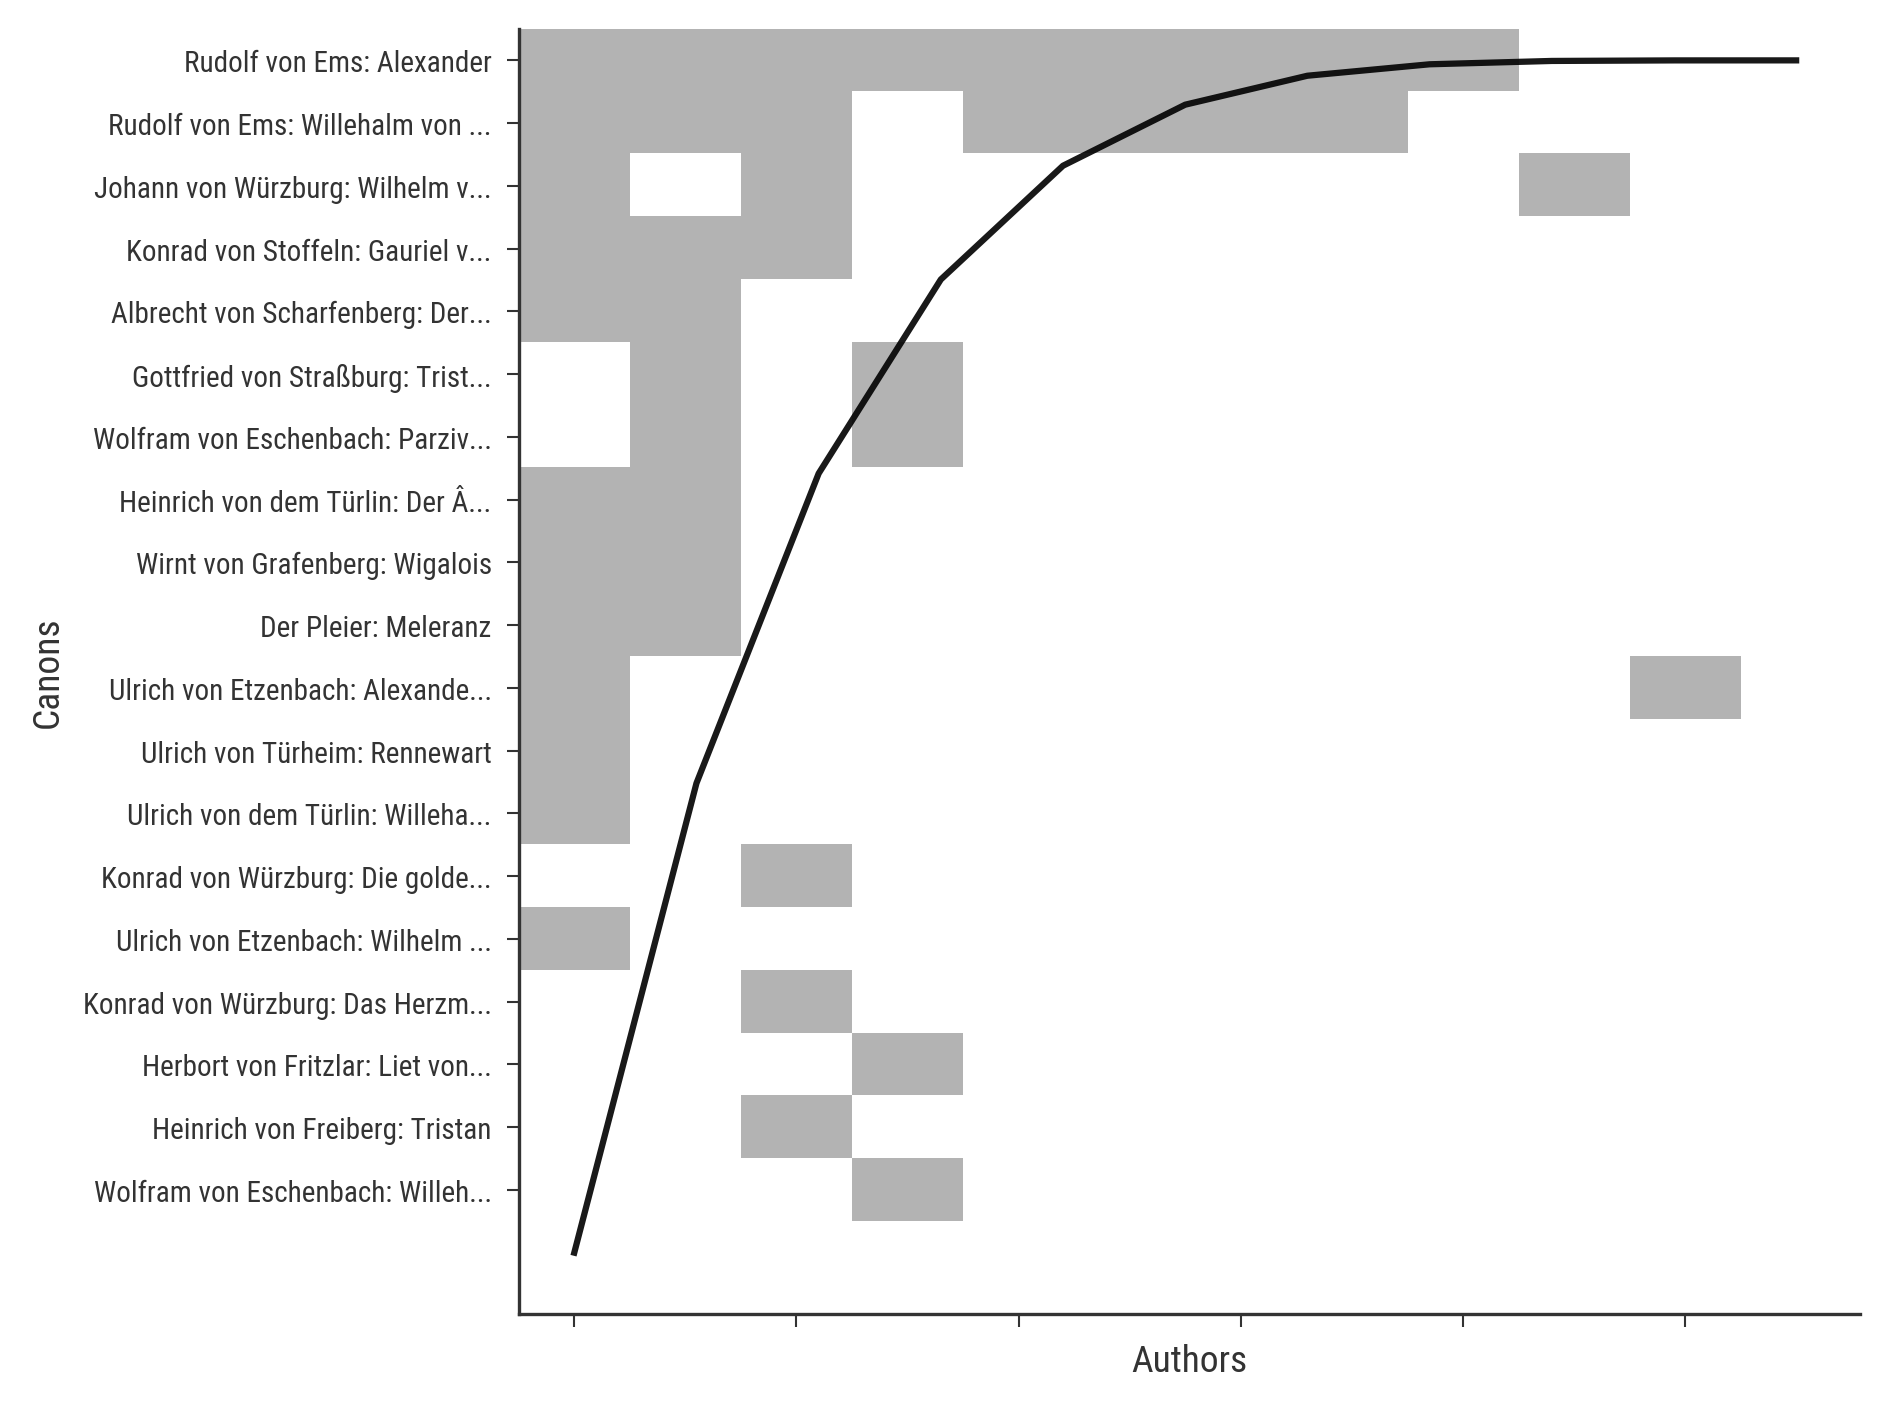

In [12]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.set_facecolor('white')
text_color = '#333333'
line_color = '#000000'

ax.imshow(matrix.values, aspect='auto', interpolation='none', cmap='Greys', alpha=0.3)

# isocline:
x = np.linspace(0, 1, matrix.shape[1])
fill = matrix.values.sum() / matrix.values.size
b = 1 / fill if fill > 0 else 1
y = 1 - (1 - x)**b
y_flipped = 1 - y

ax.plot(x * matrix.shape[1], y_flipped * matrix.shape[0], 
        color=line_color, alpha=0.9, lw=1.5)

ax.set_xlabel('Authors', fontsize=9, color=text_color)
ax.set_ylabel('Canons', fontsize=9, color=text_color)
ax.set_yticks(np.arange(matrix.shape[0]))
ax.set_yticklabels([label[:30] + '...' if len(label) > 30 else label 
                    for label in matrix.index], fontsize=7, color=text_color)

ax.tick_params(axis='both', labelsize=7, colors=text_color, length=3, width=0.5)
ax.tick_params(axis='x', labelbottom=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

plt.tight_layout()
plt.savefig('../figures/nestedness_matrix-epics.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [13]:
result = nodf_significance(matrix.values, n_permutations=1000)

print(f"Observed NODF: {result['observed']:.2f}°")
print(f"Null expectation: {result['null_mean']:.2f} ± {result['null_std']:.2f}")
print(f"z-score: {result['z_score']:.2f}")
print(f"p-value: {result['p_value']:.3f}")
print(f"Valid permutations: {result['n_valid']}/{1000}")

100%|██████████| 1000/1000 [00:00<00:00, 2536.76it/s]

Observed NODF: 58.15°
Null expectation: 38.43 ± 3.49
z-score: 5.65
p-value: 0.000
Valid permutations: 1000/1000


The citation data for the subset of epic authors clearly exhibits an even stronger nestedness (NODF = 55.14°) then the full dataset, with observed values far exceeding random expectations (null mean = 28.41 ± 2.04, z = 13.11, p < 0.001). This suggests that epic literature demonstrates even more pronounced hierarchical referencing patterns, with   a core group of authoritative individuals. Generic boundaries indeed may have intensified the concentration of literary authority in this period.